#Fake detector
## Adam Paleczny, Mikołaj Słowikowski, Jarosław Skwarczek

In [15]:
!pip install tensorflow-addons -q
!pip install scikit-plot -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.2 MB/s eta 0:00:00


In [1]:
import numpy as np
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
from sklearn.metrics               import confusion_matrix                              # generate confusion matrix
from sklearn.metrics               import accuracy_score, recall_score, precision_score # performance assessment

In [16]:
import seaborn                as sns    # statistical data visualization
import tensorflow             as tf     # build machine learning models
import scikitplot             as skplt  # data visualization and machine-learning metrics

from tensorflow                    import keras                                         # build deep learning models
from wordcloud                     import WordCloud, STOPWORDS, ImageColorGenerator     # create wordcloud
from sklearn.model_selection       import train_test_split                              # split into training and test sets
from keras.preprocessing.text      import Tokenizer                                     # create tokens
from keras.preprocessing.sequence  import pad_sequences                                 # create padding
from keras.optimizers              import Adam                                          # optimizer for training neural networks
from sklearn.metrics               import confusion_matrix                              # generate confusion matrix
from sklearn.metrics               import accuracy_score, recall_score, precision_score # performance assessment
from sklearn.metrics               import classification_report
from sklearn.linear_model          import LogisticRegression
from keras.models                  import Sequential
from keras.layers                  import Embedding, Dense, LSTM
from keras.preprocessing.sequence  import pad_sequences
from keras.preprocessing.text      import one_hot

In [2]:
DATA = "/content/gdrive/My Drive/Projekt_MIO/dataset_PL/converted-exp-PL.tsv"

In [4]:
from google.colab import drive
import os
drive.mount('/content/gdrive')
os.chdir('/content/gdrive/My Drive/')

Mounted at /content/gdrive


## Data

In [5]:
df = pd.read_csv(DATA,sep='\t')
df.head()

,politicianID,name,party,statementID,statementText,statementState,statementExplanClean,statementExplan
0,1,Paweł Szałamacha,Prawo i Sprawiedliwość,1,"Pamiętamy, że w latach 2006-2007, kiedy rządzi...",TRUE,Według danych Banku Światowego wzrost polskieg...,"<p><span>Według danych </span><a href=""http://..."
1,1,Paweł Szałamacha,Prawo i Sprawiedliwość,2,"Jeżeli patrzymy na dane dla OECD, to Polska je...",TRUE,"Według danych z OECD, Polska znajduje się poni...","<p><span>Według </span><a href=""http://www.oec..."
2,1,Paweł Szałamacha,Prawo i Sprawiedliwość,3,Po kilkuletnim okresie dodatniego przyrostu na...,TRUE,Liczba urodzonych dzieci w Polsce na 1000 mies...,"<p><a href=""http://www.indexmundi.com/g/g.aspx..."
3,1,Paweł Szałamacha,Prawo i Sprawiedliwość,4,Jeszcze dwa dni wcześniej Bank Światowy podwyż...,TRUE,Według danych Banku Światowego zawartych w ana...,<p><span>Według danych Banku Światowego zawart...
4,1,Paweł Szałamacha,Prawo i Sprawiedliwość,5,Jeszcze dzień wcześniej Międzynarodowy Fundusz...,TRUE,W dniu 13 stycznia 2016 r. na stronie Międzyna...,<p><span>W dniu 13 stycznia 2016 r. na stronie...


In [6]:
df.columns

Index(['politicianID', 'name', 'party', 'statementID', 'statementText',
       'statementState', 'statementExplanClean', 'statementExplan'],
      dtype='object')

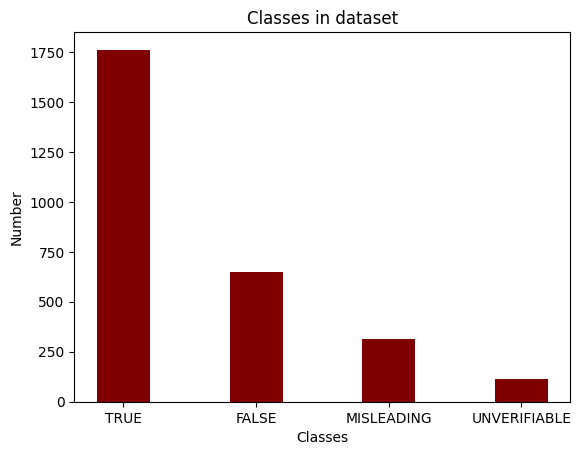

In [7]:
categories = df['statementState'].value_counts()

plt.bar(categories.index, categories.values, color ='maroon',
        width = 0.4)

plt.xlabel("Classes")
plt.ylabel("Number")
plt.title("Classes in dataset")
plt.show()

In [8]:
# How many empty labels
df.isnull().sum()

politicianID            0
name                    0
party                   0
statementID             0
statementText           0
statementState          0
statementExplanClean    0
statementExplan         0
dtype: int64

##Prepare for training

In [9]:
# create the 'clean_text' function that receives the 'text' argument
def clean_text(text):
    # create variable 'word' and divide the text by words and use whitespace as delimiter
    words = str(text).split()

    # convert words to lowercase by adding space to the end of each word
    words = [i.lower() + " " for i in words]

    # join words into a single string, but separated by spaces
    words = " ".join(words)

    # remove punctuation from strings, using the st.punctuation method as an argument
    words = words.translate(words.maketrans('', '', string.punctuation))

    return words

In [24]:
df['statementText'] = df['statementText'].apply(clean_text)
df['name'] = df['name'].apply(clean_text)
df['party'] = df['party'].apply(clean_text)

In [46]:
df = df.drop(columns=['politicianID', 'statementID', 'statementExplanClean', 'statementExplan'])

In [56]:
df['statementState'].value_counts()

statementState
TRUE            1761
FALSE            648
MISLEADING       313
UNVERIFIABLE     113
Name: count, dtype: int64

In [57]:
train, df_temp = train_test_split(df, test_size=0.25, stratify=df['statementState'], shuffle=True, random_state=123)
validation, test = train_test_split(df, test_size=0.5,stratify=df['statementState'], shuffle=True, random_state=123)
statementStateMap = { "FALSE": 0, "TRUE": 1, "UNVERIFIABLE": 2, "MISLEADING": 3 }

In [ ]:
# converting strings to numbers of test Data
def convertToNumbers(x_data_of_strings, y_data_of_strings, vocab_size, sent_length):
    onehot_rep_train = [one_hot(word, vocab_size) for word in x_data_of_strings]
    ebedded_doc_train = pad_sequences(onehot_rep_train, padding='pre', maxlen = sent_length)
    state_train = np.array(list(map(statementStateMap.get, y_data_of_strings)))
    return ebedded_doc_train, state_train

## Sequence Model

In [ ]:
def SequenceModel():
    # some constants
    vocab_size = 20000
    features = 40
    sent_length = 120

    X_train, Y_train = convertToNumbers(train['statementText'], train['statementState'], vocab_size, sent_length)
    X_test, Y_test = convertToNumbers(validation['statementText'], validation['statementState'], vocab_size, sent_length)

    model = Sequential()
    model.add(Embedding(vocab_size, features, input_length = sent_length))
    model.add(LSTM(100))
    # In Keras, LSTM layer LSTM(100), the number 100 represents the number of units or neurons in the LSTM layer.
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam' , metrics=['accuracy'])
    print(model.summary())

    model.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs = 10 , batch_size=64)

    y_pred = np.where(model.predict(X_test) > 0.5, 1,0)
    print(np.sum(y_pred) / y_pred.shape[0])

In [ ]:
def LogisticRegressionModel():
    model = LogisticRegression()

    vocab_size = 20000
    sent_length = 120
    X_train, Y_train = convertToNumbers(train['statementText'], train['statementState'], vocab_size, sent_length)

    model.fit(X_train, Y_train)

    X_train_prediction = model.predict(X_train)
    training_data_accuracy = accuracy_score(X_train_prediction, Y_train)
    print(training_data_accuracy)